# Comparison of the networks for all time steps

In [1]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import networkx as nx
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
import time
from upsetplot import from_contents, UpSet
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from IPython.core.display import SVG
import gseapy
from gseapy.plot import barplot, dotplot
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Import custom libraries
import pcst_utils_3 as pcst

In [24]:
# Reload modules in case of modifications
reload(pcst)

<module 'pcst_utils_3' from '/home/braunger/masterthesis/python_code/PCST/pcst_utils_3.py'>

In [25]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"
fig_dir = "/home/braunger/masterthesis/save/figures/pcst/"

# Significant TFs

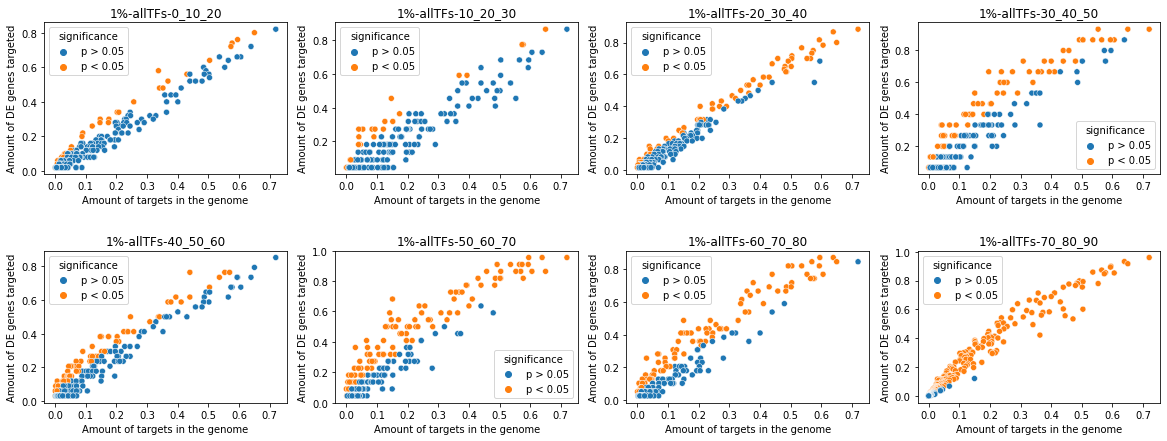

In [26]:
net_dir = pcst.get_net_dir_all_stages(save_dir, "allTFs", "1%")
net_stats, target_counts = pcst.compare_networks(net_dir, data_dir, fig_dir, save_dir)

# General network statistics


In [27]:
net_stats.iloc[:, 0:8]

,n_nodes,n_edges,n_prized_nodes,n_Steiner_nodes,n_TFs,n_incl_TFs,n_prized_TFs,n_significant_TFs
1%-allTFs-0_10_20,544,12181,418,126,275,227,212,34
1%-allTFs-10_20_30,572,12267,414,158,234,193,184,24
1%-allTFs-20_30_40,533,12784,426,107,278,226,209,66
1%-allTFs-30_40_50,605,13493,424,181,249,208,197,72
1%-allTFs-40_50_60,483,11168,389,94,269,220,210,74
1%-allTFs-50_60_70,526,12141,405,121,251,206,197,111
1%-allTFs-60_70_80,501,11964,403,98,256,212,200,99
1%-allTFs-70_80_90,1724,85965,1583,141,415,358,315,259


# Intersections of the TFs

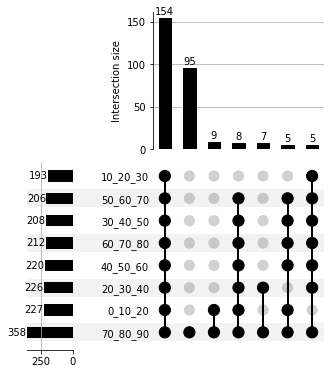

In [28]:
incl_TFs = [[tf[:-4] for tf in net_stats.iloc[net, 8]] for net in range(8)]

intersections = from_contents({'0_10_20': incl_TFs[0], 
                               '10_20_30': incl_TFs[1],
                               '20_30_40': incl_TFs[2],
                               '30_40_50': incl_TFs[3], 
                               '40_50_60': incl_TFs[4],
                               '50_60_70': incl_TFs[5],
                               '60_70_80': incl_TFs[6],
                               '70_80_90': incl_TFs[7]})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 5).plot()

plt.savefig(fig_dir+'intersections_allTFs_top10.png')

# Analyses of the TFs that occur in all 8 networks

## Percentage of differentially expressed genes that are targeted

In [49]:
# Get number of DE targets for the TFs in each of the networks
targets_shared_TFs = pd.DataFrame(index = set.intersection(*map(set,incl_TFs)))

for index, (name, df) in enumerate(target_counts.items()):
    df.index = df.index.str.replace("_tr0", "")
    if index == 0: 
        df = df[['percent_genome_targets', 'percent_DE_targeted']]
        df.columns = ['percent_genome_targets', name.split("-")[2]]
    else:
        df = df[['percent_DE_targeted']]
        df.columns = [name.split("-")[2]]
    targets_shared_TFs = targets_shared_TFs.join(df)
    
targets_percent = targets_shared_TFs.iloc[:,1:].div(targets_shared_TFs.percent_genome_targets, axis=0)
targets_shared_TFs.head()

,percent_genome_targets,0_10_20,10_20_30,20_30_40,30_40_50,40_50_60,50_60_70,60_70_80,70_80_90
STAT5B,0.047813,0.08,0.090909,0.083333,0.266667,0.147059,0.227273,0.128205,0.093513
UBTF,0.106342,0.08,0.136364,0.133333,0.266667,0.147059,0.318182,0.205128,0.279697
ZNF143,0.049608,0.08,0.045455,0.033333,0.133333,0.058824,0.136364,0.102564,0.133109
SIX5,0.069735,0.08,0.090909,0.066667,0.133333,0.088235,0.136364,0.076923,0.203875
GMEB2,0.087467,0.20,0.045455,0.083333,0.266667,0.117647,0.136364,0.102564,0.235046


## TF correlations 

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

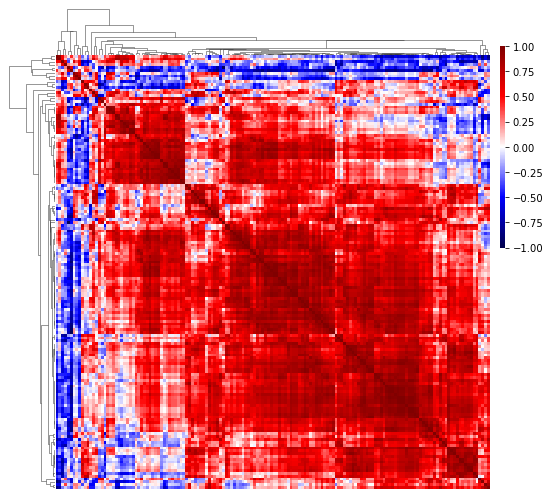

In [30]:
# Correlation between the TFs
corr_TFs = targets_shared_TFs.iloc[:, 1:].T.corr(method = "spearman")
plt.figure()
sns.clustermap(corr_TFs,
               method='average',
               metric='cosine',
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.5, 0.01, .4),
               dendrogram_ratio=(.1, .1),
               vmin = -1, vmax = 1, figsize=(7,7))
plt.show()

## Analyses of the clusters

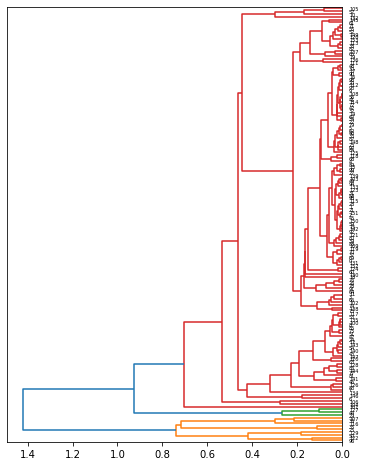

In [56]:
dend = linkage(corr_TFs, 
               method='average', metric='cosine')
plt.figure(figsize = (6, 8))
dendrogram(dend, orientation = "left", color_threshold = 0.8)
plt.show()

In [57]:
TF_clusters = pd.DataFrame({'TF': corr_TFs.index, 
                            'cluster': fcluster(dend, 0.8, criterion = 'distance')})
TF_clusters['cluster'].value_counts()

3    142
1      9
2      3
Name: cluster, dtype: int64

In [50]:
targets_percent.reset_index(inplace=True)

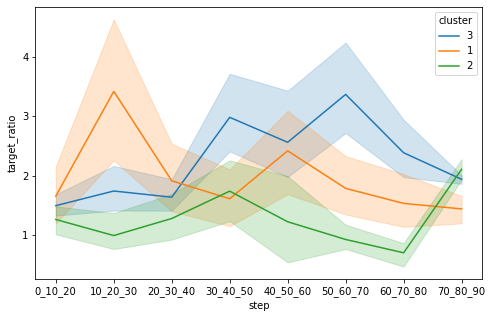

In [58]:
# plot trajectory of the number of targets in the two clusters
targets_long = pd.melt(targets_percent, id_vars = ['index'],
       var_name='step', value_name = 'target_ratio')
targets_long.columns = ['TF', 'step', 'target_ratio']
targets_long = targets_long.merge(TF_clusters)
targets_long['cluster'] = targets_long['cluster'].astype(str)

plt.figure(figsize = (8, 5))
sns.lineplot(data=targets_long,
             x='step', y='target_ratio',
             hue="cluster")

plt.show()

In [59]:
# Create network
# Threshold correlation matrix
corr_TFs_0 = corr_TFs.copy()
corr_TFs_0[corr_TFs_0 < 0.7] = 0

corr_long = pd.melt(corr_TFs_0.reset_index(), id_vars='index')
corr_long = corr_long[(corr_long['value'] > 0) & (corr_long['index'] != corr_long['variable'])]
corr_long.columns = ['protein1', 'protein2', 'corr']
corr_long

network = nx.from_pandas_edgelist(corr_long, 'protein1', 'protein2', 'corr')
# add clusters as node attributes
clusters = {TF: TF_clusters.loc[TF_clusters['TF'] == TF, 'cluster'].tolist() for TF in list(network.nodes())}
nx.set_node_attributes(network, clusters, name='cluster')
oi.output_networkx_graph_as_interactive_html(network, filename=save_dir + "TF_corr_0.7.html")

PosixPath('/home/braunger/masterthesis/save/pcst/TF_corr_0.7.html')

# Intersections of the Steiner nodes

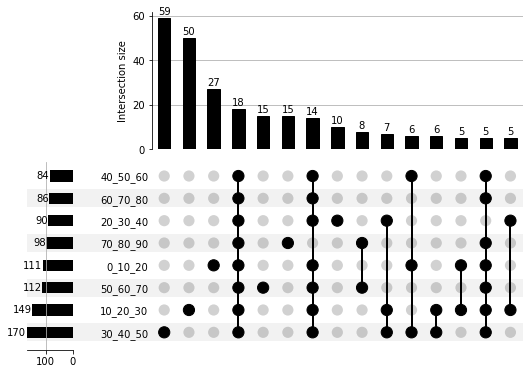

In [60]:
steiner_nodes = [[node[:-4] for node in net_stats.iloc[net, 10]] for net in range(8)]

intersections = from_contents({'0_10_20': steiner_nodes[0], 
                               '10_20_30': steiner_nodes[1],
                               '20_30_40': steiner_nodes[2],
                               '30_40_50': steiner_nodes[3], 
                               '40_50_60': steiner_nodes[4],
                               '50_60_70': steiner_nodes[5],
                               '60_70_80': steiner_nodes[6],
                               '70_80_90': steiner_nodes[7]})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 5).plot()

plt.savefig(fig_dir+'intersections_steiner_10%.png')

What are the Steiner nodes occuring in all of the networks?

In [68]:
set.intersection(*map(set,steiner_nodes))

{'BRCA2',
 'DAXX',
 'EIF4G1',
 'HNRNPD',
 'NKX2-5',
 'NTF3',
 'NTRK3',
 'PKNOX1',
 'SHC1',
 'SIN3B',
 'SIRT1',
 'SMAD6',
 'SMG5',
 'SNAPC3',
 'TERT',
 'TRADD',
 'WRN',
 'XRCC6'}

In [67]:
set.intersection(*map(set,steiner_nodes[:7])).difference(steiner_nodes[7])

{'BAP1',
 'CASP8',
 'CDC6',
 'ELL',
 'H3-3A',
 'H3C1',
 'KRR1',
 'NBN',
 'PDCD11',
 'RELB',
 'RPS14',
 'SCAP',
 'TERF2',
 'UTP4'}